In [1]:
import os,sys
sys.path.append('/home/cs341seti/cs341-ibm-seti/')
import numpy as np
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu
import PIL
from PIL import Image
import model_specs

Using TensorFlow backend.


In [2]:
import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# Experimenting with images

In [3]:
### Loading saved npy files
# Loading in saved subset of data files 
subsetComplexSignals = np.load('complexSignalsSubset.npy')[()]
subsetSpectrograms = np.load('specSubset.npy')[()]

## Trying out binning techniques

Trying out some code from https://gist.github.com/derricw/95eab740e1b08b78c03f to average along x-axis. 
Also experimenting with reshaping / resizing the image

In [4]:
def showImageFromSpec(spec,imsize,binFactor,colmap,save=False,filename=None):
    specShape = spec.shape
    spec = cu.nputils.bin_ndarray(spec[1:,:],(specShape[0]-1,specShape[1]/binFactor),operation='average')
    dpi = 96.0
    fig = plt.figure(frameon=False,figsize=(imsize[0]/dpi,imsize[1]/dpi))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # fig, ax = plt.subplots(figsize=(20, 10))
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
    plt.set_cmap(colmap)
    ax.imshow(np.log(spec), aspect = 'auto')
    plt.show()

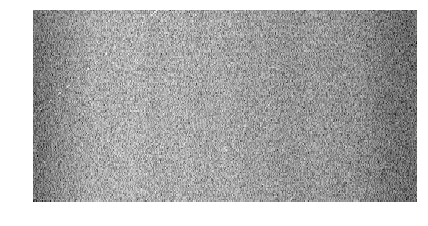

In [5]:
# spec = subsetSpectrograms['narrowband'][1]
# spec = subsetSpectrograms['squiggle'][1]
# spec = subsetSpectrograms['squigglesquarepulsednarrowband'][2]
spec = subsetSpectrograms['squarepulsednarrowband'][0]
showImageFromSpec(spec,(512,256),8,'gray',save=False,filename="resized_spec")

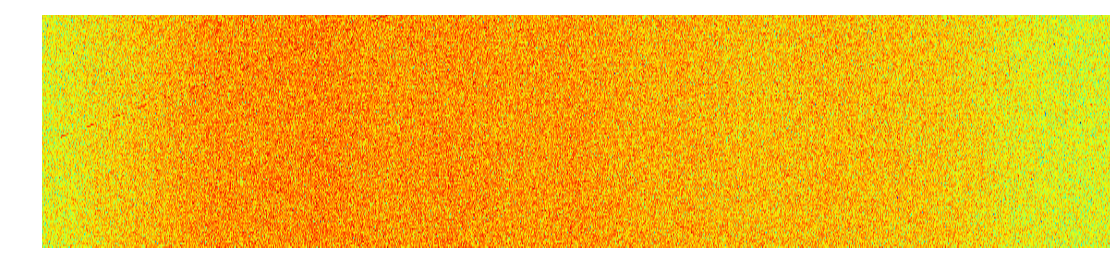

In [52]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 3 to 128x2048
showImageFromSpec(spec,(1024,224),3,save=False,filename="resized_spec")

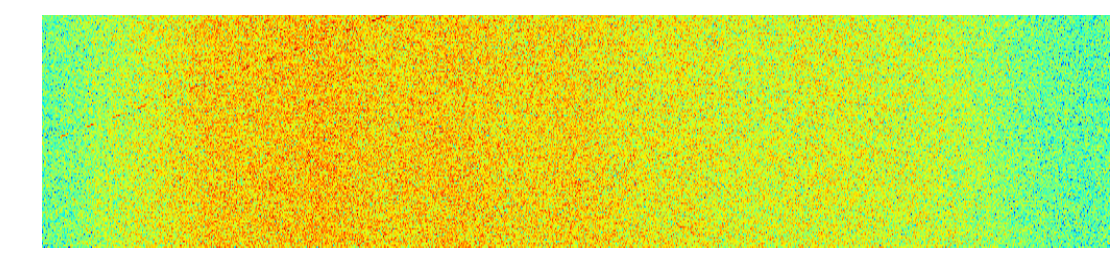

In [53]:
# Using code from https://gist.github.com/derricw/95eab740e1b08b78c03f, reducing along x axis
# Seeing how much file can be reduced in size. Ignoring first row to make it 128x6144
# Then factoring down on x-axis by 6 to 128x1024
showImageFromSpec(spec,(1024,224),6,save=False,filename="resized_spec")

## Converting all files to images (skip if already exists)

In [ ]:
# Run through directory 
specPath = "../data/specdataraw/"
binFactor = 8
image_size = (512,256)
savePath = "../data/specdataimages_gray_{}x{}_{}/".format(image_size[0],image_size[1],binFactor)
os.system("mkdir -p "+savePath)
specfiles = [f for f in os.listdir(specPath) if os.path.isfile(os.path.join(specPath, f))]
for i in range(len(specfiles)):
    # Convert and save each file as image
    fname = specfiles[i].split(".")[0]
    print "\r{0}".format(i),
    spec = np.load("{}{}.npy".format(specPath,fname))
    cu.datautils.saveImageFromSpec(spec,image_size,binFactor,'gray',save=True,filename="{}{}".format(savePath,fname))

## Saving a sample of images - to send to Andreas

In [5]:
subsetSpectrograms.keys()

['noise',
 'squiggle',
 'narrowbanddrd',
 'brightpixel',
 'narrowband',
 'squigglesquarepulsednarrowband',
 'squarepulsednarrowband']

In [6]:
for key in subsetSpectrograms.keys():
    for i in range(len(subsetSpectrograms[key])):
        %%system mkdir -p sampleImages_small_size
        spec = subsetSpectrograms[key][i]
        fname = "./sampleImages_small_size/{}_{}".format(key,i)
        cu.datautils.saveImageFromSpec(spec,(448,224),4,save=True,filename=fname) # Creating smaller size images!

In [ ]:
# Loading in table with info on files
fileListDF = pd.read_csv("fileList_basic4.csv")

# VGG Model activations

## Individually examining activations

In [54]:
# Loading in table with info on files
fileListDF = pd.read_csv("fileList_basic4.csv")
# Loading in an arbitrary file
imgPath = "data/specdataimages_basic4_1024x224_3/"
fnum = 50
imgfiles = [f for f in os.listdir(imgPath) if os.path.isfile(os.path.join(imgPath, f))]
image = np.asarray(Image.open(os.path.join(imgPath,imgfiles[fnum])))
print imgfiles[fnum]
print fileListDF.ix[int(imgfiles[fnum].split(".")[0])]

000801.jpg
file_name                cfd92eaf-17ca-44e2-939f-f274b677e1c1.dat
signal_classification                               narrowbanddrd
uuid                         cfd92eaf-17ca-44e2-939f-f274b677e1c1
file_index                                                    801
label                                                           2
Name: 801, dtype: object


jet


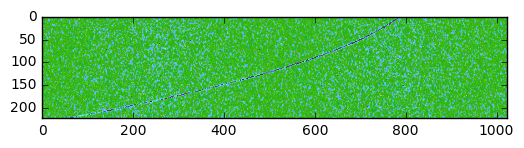

In [55]:
image = image.astype('float32')
image = np.expand_dims(image,axis=0)
image = preprocess_input(image)
print plt.get_cmap().name
plt.imshow(image[0])
plt.show()

commonutils/datautils.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
  model_selection = Model(input=model.input, output=model.get_layer(layer_name).output)


(1, 28, 128, 256)
(2, 2)
(2, 2)


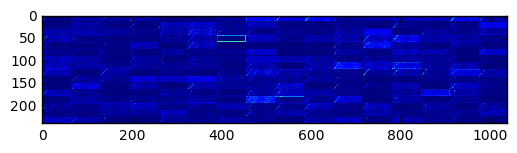

In [15]:
# Loading in the model
base_model = VGG16(weights='imagenet', include_top=False)
# Viewing VGG activations on the entire image 
imageAct = cu.datautils.modelActivations(base_model,'block3_pool',image,poolfit=(14,64),save=True,show=True)

## Generating all activations (skip if already exists)

In [ ]:
# Point to directory
# Call model activations function
readDir = "data/specdataimages/"
writeDir = "data/specdataactivations/"
layerName = "block3_pool"
poolfitSize = None
cu.datautils.generateAllActivations(readDir,writeDir,layerName,poolfitSize)

## Creating combined activations file (skip if done)

In [23]:
fileListDF = pd.read_csv("fileList.csv",dtype={'file_index':str})
fileListDF.groupby("signal_classification").count()

,file_name,uuid,file_index,label
signal_classification,,,,
brightpixel,2000,2000,2000,2000
narrowband,1997,1997,1997,1997
narrowbanddrd,3995,3995,3995,3995
noise,1998,1998,1998,1998
squarepulsednarrowband,1998,1998,1998,1998
squiggle,1997,1997,1997,1997
squigglesquarepulsednarrowband,2000,2000,2000,2000


In [13]:
## Assigning numbers to classes
labelMap = {'noise':0,'brightpixel':1,'narrowband':2,
            'narrowbanddrd':3,'squarepulsednarrowband':4,'squiggle':5,'squigglesquarepulsednarrowband':6}
# fileListDF["label"] = fileListDF["signal_classification"].apply(lambda x: labelMap[x])
# fileListDF.to_csv("fileList.csv",index=False)
print labelMap
fileListDF.ix[0:5]

{'noise': 0, 'squiggle': 5, 'narrowbanddrd': 3, 'brightpixel': 1, 'narrowband': 2, 'squigglesquarepulsednarrowband': 6, 'squarepulsednarrowband': 4}


,file_name,signal_classification,uuid,file_index,label
0,00069203-0824-4136-9c99-b9f68672f23d.dat,squigglesquarepulsednarrowband,00069203-0824-4136-9c99-b9f68672f23d,000000,6
1,000739aa-89d6-4965-abf6-9b46a246604a.dat,narrowband,000739aa-89d6-4965-abf6-9b46a246604a,000001,2
2,000874dd-8d6e-44b1-8ade-21aeb5a29546.dat,narrowbanddrd,000874dd-8d6e-44b1-8ade-21aeb5a29546,000002,3
3,0009073c-4032-4b84-832a-9b81fc3b0df8.dat,brightpixel,0009073c-4032-4b84-832a-9b81fc3b0df8,000003,1
4,000c28b3-aeba-4f18-ac60-b91341921264.dat,squigglesquarepulsednarrowband,000c28b3-aeba-4f18-ac60-b91341921264,000004,6
5,000eb18b-326f-4488-9f07-b7382c01bf91.dat,narrowband,000eb18b-326f-4488-9f07-b7382c01bf91,000005,2


## Combine all activations from folder and save to a file 

In [56]:
## Read in all files from directory and combine them into train/val/test datasets
readDir = "data/specdataactivations_basic4_b5_1024x224_3/"
nvalidation = 1
ntest = 1
cu.datautils.createActivationsDataset(readDir,"fileList_basic4.csv",nvalidation,
                                      ntest,'data/activations_basic4_b5_1024x224_3.h5')

Picking files of extension npy
The number of files is 1000
Training set 998 / 998 

Validation set 1 / 1 

Test set 1 / 1 

Dim of data: 114688
Number of training images = 998
Number of validation images = 1
Number of test images = 1
Distribution in training data:
0 - 249
1 - 250
2 - 250
3 - 249
Distribution in validation data:
0 - 1
1 - 0
2 - 0
3 - 0
Distribution in test data:
0 - 0
1 - 0
2 - 0
3 - 1


In [4]:
dataset.keys()

['train_ids',
 'x_val',
 'x_train',
 'y_train',
 'val_ids',
 'y_val',
 'x_test',
 'y_test',
 'test_ids']

## Experimenting with fine-tuned model

In [4]:
model = model_specs.vgg_fine_tune.build((224,224,3),4,
                                "./savedModels/224x224_1024-256-256_4class_rmsproplr0.0001decay1e-06.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

000167.jpg
file_name                0275169d-361b-4393-a295-f43bfe59ede8.dat
signal_classification                               narrowbanddrd
uuid                         0275169d-361b-4393-a295-f43bfe59ede8
file_index                                                    167
label                                                           3
Name: 167, dtype: object
jet


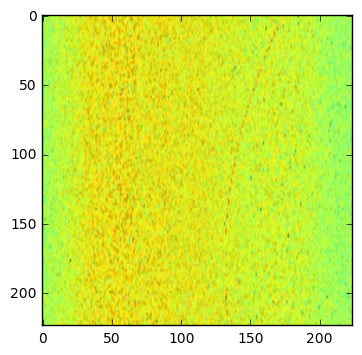

In [10]:
# Loading in table with info on files
fileListDF = pd.read_csv("fileList.csv")
# Loading in an arbitrary file
imgPath = "data/specdataimages/"
fnum = 25
imgfiles = [f for f in os.listdir(imgPath) if os.path.isfile(os.path.join(imgPath, f))]
img = image.load_img(os.path.join(imgPath,imgfiles[fnum]),target_size=(224,224))
print imgfiles[fnum]
print fileListDF.ix[int(imgfiles[fnum].split(".")[0])]

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print plt.get_cmap().name
plt.imshow(img)
plt.show()

In [11]:
print model.predict(x) 
print np.argmax(model.predict(x))

[[  9.92801905e-01   1.01716455e-10   3.49454454e-14   7.19810091e-03]]
0


## Combine and create dataset of images

In [4]:
## Read in all files from directory and combine them into train/val/test datasets
readDir = "data/specdataimages224x224_8/"
nvalidation = 3000
ntest = 1500
cu.datautils.createDataset(readDir,"fileList.csv",nvalidation,ntest,'data/images_224x224_8.h5',loadImages=True)

Picking files of extension jpg
The number of files is 15985
Training set 11485 / 11485 

Validation set 3000 / 3000 

Test set 1500 / 1500 

Dim of data: 224
Number of training images = 11485
Number of validation images = 3000
Number of test images = 1500
Distribution in training images: 
0 - 1471 
1 - 1430 
2 - 1428 
3 - 2877 
4 - 1444
Distribution in validation images: 
0 - 349 
1 - 377 
2 - 368 
3 - 755 
4 - 378
Distribution in test images: 
0 - 178 
1 - 193 
2 - 201 
3 - 363 
4 - 176


In [6]:
sourcePath = "data/specdataimages224x224_8/"
fileList = pd.read_csv("fileList.csv",dtype={'file_index':str})

In [7]:
files = [f for f in os.listdir(sourcePath)]
ext = list(set([f.split('.')[1] for f in files]))[0]
print 'Picking files of extension %s' % ext
files = [f for f in files if f.endswith(ext)]

Picking files of extension jpg


## Reorganising image files into train/val/test folders

In [14]:
# Loading in table with info on files
fileListDF = pd.read_csv("../data/fileList.csv",dtype={'file_index':str})
fileListDF.groupby(['dataset','signal_classification']).agg('count')

file_name  uuid  file_index  label
dataset    signal_classification                                             
test       brightpixel                           200   200         200    200
           narrowband                            185   185         185    185
           narrowbanddrd                         349   349         349    349
           noise                                 185   185         185    185
           squarepulsednarrowband                192   192         192    192
           squiggle                              186   186         186    186
           squigglesquarepulsednarrowband        203   203         203    203
train      brightpixel                          1497  1497        1497   1497
           narrowband                           1531  1531        1531   1531
           narrowbanddrd                        3018  3018        3018   3018
           noise                                1526  1526        1526   1526
           squarepulsednarrowband               1503  1503        1503   1503
           squiggle                             1509  1509        1509   1509
           squigglesquarepulsednarrowband       1501  1501        1501   1501
validation brightpixel                           303   303         303    303
           narrowband                            281   281         281    281
           narrowbanddrd                         628   628         628    628
           noise                                 287   287         287    287
           squarepulsednarrowband                303   303         303    303
           squiggle                              302   302         302    302
           squigglesquarepulsednarrowband        296   296         296    296

In [17]:
# Saving the train/val/test IDs split 
# nval = 2400
# ntest = 1500
# ntrain = fileListDF.shape[0]-nval-ntest
# fileListDF['dataset'] = 'train'
# fileListDF.loc[ntrain:ntrain+nval,'dataset'] = 'validation'
# fileListDF.loc[ntrain+nval:ntrain+nval+ntest,'dataset'] = 'test'
# # fileListDF.to_csv("../data/fileList.csv",index=False)
# fileListDF.groupby(['dataset','signal_classification']).agg('count')

In [4]:
nval = 2400
ntest = 1500
ntrain = fileListDF.shape[0]-nval-ntest
sourceDir = "../data/specdataimages_gray_512x256_8/"
destDir = "../data/imagesDataset_512x256_8/"

os.system("mkdir -p "+destDir)
for i in fileListDF[fileListDF['dataset']=='train'].index:
    labelDir = "{}-{}".format(fileListDF['label'].ix[i],fileListDF['signal_classification'].ix[i])
    os.system("mkdir -p "+os.path.join(destDir,"train",labelDir))
    fname = os.path.join(sourceDir,"{}.jpg".format(fileListDF['file_index'].ix[i]))
    os.system("cp {} {}".format(fname,os.path.join(destDir,"train",labelDir)))
    print "\rTraining: {}".format(i),
for i in fileListDF[fileListDF['dataset']=='validation'].index:
    labelDir = "{}-{}".format(fileListDF['label'].ix[i],fileListDF['signal_classification'].ix[i])
    os.system("mkdir -p "+os.path.join(destDir,"validation",labelDir))
    fname = os.path.join(sourceDir,"{}.jpg".format(fileListDF['file_index'].ix[i]))
    os.system("cp {} {}".format(fname,os.path.join(destDir,"validation",labelDir)))
    print "\rValidation: {}".format(i),
for i in fileListDF[fileListDF['dataset']=='test'].index:
    labelDir = "{}-{}".format(fileListDF['label'].ix[i],fileListDF['signal_classification'].ix[i])
    os.system("mkdir -p "+os.path.join(destDir,"test",labelDir))
    fname = os.path.join(sourceDir,"{}.jpg".format(fileListDF['file_index'].ix[i]))
    os.system("cp {} {}".format(fname,os.path.join(destDir,"test",labelDir)))
    print "\rTest: {}".format(i),

Test: 15984 14484                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Creating a single dataset file as well

In [3]:
## Read in all files from directory and combine them into train/val/test datasets
readDir = "../data/specdataimages_gray_512x256_8/"
cu.datautils.createDataset(readDir,"../data/fileList.csv",
                           '../data/imagesDataset_512x256_8/imagesDataset_512x256_8.h5',
                           loadImages=True,grayscale=True)

Picking files of extension jpg
The number of files is 15985
train set: 12085 / 12085                                                                                                                                                                                                                                                    

validation set: 2400 / 2400                                                                        

test set: 1500 / 1500                                           

Dim of data: 256
Number of training images = 12085
Number of validation images = 2400
Number of test images = 1500
Distribution in training data:
0 - 1526
1 - 1497
2 - 1531
3 - 3018
4 - 1503
5 - 1509
6 - 1501
Distribution in validation data:
0 - 287
1 - 303
2 - 281
3 - 628
4 - 303
5 - 302
6 - 296
Distribution in test data:
0 - 185
1 - 200
2 - 185
3 - 349
4 - 192
5 - 186
6 - 203


11